In [1]:
import xlrd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# 1.0. Parsing Excel File 

In [2]:
#Converting excel file to pandas dataframe
book = xlrd.open_workbook("Line_list.xlsx")
sheet = book.sheet_by_name("Sheet4")
features = ["", "UNIT1", "SECTION", "PIPING_GROUP", "OLD_PIPING_GROUP", "DESCRIPTION", "DIAM(INCHES)", "DIAM(MM)", "UNIT", "FLUID_CODE", "LINE_NUMBER", "PIPING_SPEC", "FROM", "TO", "FLUID", "PHASE", "DENSITY(KG/M3)", "MASS_RATE(KG/H)", "OPERATING_PRESS(BARG)", "OPERATING_TEMP(C)", "DESIGN_PRESS(BARG)", "DESIGN_TEMP(C)", "ALT1_OTHER_OP_PRESS(BARG)", "ALT1_OTHER_OP_TEMP(C)", "ALT1_OTHER_DES_PRESS(BARG)", "ALT1_OTHER_DES_TEMP(C)", "ALT2_OTHER_OP_PRESS(BARG)", "ALT2_OTHER_OP_TEMP(C)", "ALT2_OTHER_DES_PRESS(BARG)", "ALT2_OTHER_DES_TEMP(C)","DESIGN_COND", "TENS_STRENGTH(MPA)", "YIELD_STRENGTH(MPA)", "1/3_TS", "2/3_TS", "TEMP_CORR", "ALLOW_STRESS(MPA)", "PIPING_SCH", "NOM_THCK(MM)", "MIN_THCK_B313", "ALARM_THCK", "MIN_REQ_THCK", "COR_AL(MM)", "INSULATION_CODE", "INSULATION_LIM", "INSULATION_THCK(MM)", "TRACING_SIZE", "TRACING_NO", "TRACING_T_MAIN", "PAINT", "PAINT2", "TRT_TH", "TRT_CHM", "TEST_PRESSURE_TYPE", "TEST_PRESSURE_MIN(BARG)", "TEST_PRESSURE_MAX(BARG)", "PED_PHASE", "PED_GROUP", "PED_CATEGORY", "CANCELLED", "REV", "PID", "NOTES", "COMMENTS", "ASSUMPTIONS", "PAINT_FLAG", "P"]
data = []
for i in range(sheet.nrows):
    if i > 9:
        data.append(sheet.row_values(i))
original_piping_df = pd.DataFrame(data, columns = features)

# 2.0. Data Preprocessing

In [3]:
#Removing unnecessary columns
drop_features = ["SECTION", "DESIGN_PRESS(BARG)","DESIGN_TEMP(C)", "", "FLUID", "FROM", "TO","UNIT1", "OLD_PIPING_GROUP", "DESCRIPTION", "DIAM(MM)", "DENSITY(KG/M3)", "MASS_RATE(KG/H)", "ALT1_OTHER_OP_PRESS(BARG)", "ALT1_OTHER_OP_TEMP(C)", "ALT1_OTHER_DES_PRESS(BARG)", "ALT1_OTHER_DES_TEMP(C)", "ALT2_OTHER_OP_PRESS(BARG)", "ALT2_OTHER_OP_TEMP(C)", "ALT2_OTHER_DES_PRESS(BARG)", "ALT2_OTHER_DES_TEMP(C)","DESIGN_COND", "TENS_STRENGTH(MPA)", "YIELD_STRENGTH(MPA)", "1/3_TS", "2/3_TS", "TEMP_CORR", "ALLOW_STRESS(MPA)", "PIPING_SCH", "NOM_THCK(MM)", "MIN_THCK_B313", "ALARM_THCK", "MIN_REQ_THCK", "COR_AL(MM)", "INSULATION_LIM", "INSULATION_THCK(MM)", "TRACING_SIZE", "TRACING_NO", "TRACING_T_MAIN", "PAINT2", "TRT_TH", "TRT_CHM", "TEST_PRESSURE_TYPE", "TEST_PRESSURE_MIN(BARG)", "TEST_PRESSURE_MAX(BARG)", "PED_PHASE", "PED_GROUP", "PED_CATEGORY", "CANCELLED", "REV", "PID", "NOTES", "COMMENTS", "ASSUMPTIONS", "PAINT_FLAG", "P"]
piping_df = original_piping_df.drop(drop_features, axis = 1)

In [4]:
#Rearranging columns
piping_df = piping_df[['DIAM(INCHES)', 'UNIT', 'FLUID_CODE', 'LINE_NUMBER','PIPING_SPEC', 'PHASE', 'OPERATING_PRESS(BARG)', 'OPERATING_TEMP(C)','INSULATION_CODE', 'PAINT', 'PIPING_GROUP']]

In [5]:
#Removing rows without piping group
piping_df = piping_df.loc[piping_df["PIPING_GROUP"] != ""]

In [6]:
#Removing piping with no operating pressure
piping_df = piping_df.loc[(piping_df["OPERATING_PRESS(BARG)"] != "")]
piping_df = piping_df.loc[(piping_df["OPERATING_PRESS(BARG)"] != "-")]

In [7]:
#Removing piping with no operating temperature
piping_df = piping_df.loc[piping_df["OPERATING_TEMP(C)"] != ""] 

In [8]:
#Removing rows with no unit value
piping_df = piping_df.loc[(piping_df["UNIT"] != "")]

In [9]:
len(piping_df.loc[piping_df["PHASE"] == ""])

12

In [10]:
#Filling piping without Phase value
piping_df.loc[(piping_df["PIPING_GROUP"] == "IPC-HG-1031-04-BD20G") & (piping_df["PHASE"] == ""), "PHASE"] = "V"
piping_df.loc[(piping_df["PIPING_GROUP"] == "IPC-HG-1031-08-BD20G") & (piping_df["PHASE"] == ""), "PHASE"] = "V"
piping_df.loc[(piping_df["PIPING_GROUP"] == "IPC-HG-1031-11-DD20G") & (piping_df["PHASE"] == ""), "PHASE"] = "V"
piping_df.loc[(piping_df["PIPING_GROUP"] == "IPC-HG-1031-12-ER20X") & (piping_df["PHASE"] == ""), "PHASE"] = "V"

In [11]:
#Changing piping spec column to the real material name
material_dict = {'AD20X': "22Cr", 'DD20H': "22Cr", 'BD20Y': "22Cr", 'AD20Y': "22Cr", 'BD20X': "22Cr", 'DD20X': "22Cr", 'AD20G': "22Cr",
       'AD75X': "25Cr", 'AD75Y': "25Cr", 'FD20X': "22Cr", 'KD02X': "25Cr", 'DD20Y': "22Cr", 'ED20X': "22Cr", 'GD20X': "25Cr",
       'BD20G': "22Cr", 'AS20X': "SS316", 'AT75X': "Ti_Gr2", 'BR20X': "6Mo", 'AD20P': "22Cr", 'AR20X': "6Mo", 'AR20Y': "6Mo",
       'KD01X': "25Cr", 'DD20G': "22Cr", 'ED20G': "22Cr", 'FD20G': "22Cr", 'FR20X': "6Mo", 'KX02X': "Ni625", 'KX01X': "Ni625",
       'FC11X': "HSLA", 'ER20X': "6Mo", 'DR20X': "6Mo", 'FC11P': "HSLA", 'FS20X': "25Cr", 'FD20S': "22Cr", 'BD20H': "22Cr",
       'DD20P': "22Cr", 'BD20Z': "22Cr", 'AD20Z': "22Cr"}

piping_df = piping_df.replace({"PIPING_SPEC": material_dict})

In [12]:
#Changing insulation code column to insulation type
insulation_dict = {"N": "N", 'P': "N", 'H': "I", 'I': "I", 'F3': "I", 'X': "I", 'Z': "I", 'HZ': "I", 'J': "I", 'JZF1': "I", 'JF1': "I", 'JF3': "I","F12": "I",'ZF3': "I", 'IF1': "I", 'F1': "I", 'ZF1': "I", 'JX': "I", 'IZ': "I", 'IF3': "I", 'IZF3': "I", 'IZF1': "I",'HZF1': "I", 'HF1': "I", 'XF1': "I", 'JZ': "I", 'Y': "I", 'PF1': "I"}
piping_df["INSULATION_CODE"] = piping_df.INSULATION_CODE.map(insulation_dict)
piping_df["INSULATION_CODE"].unique()

array(['N', 'I'], dtype=object)

In [13]:
#Convert string to float for columns containing numbers
for col in piping_df.columns:
    if col == "UNIT":
        piping_df[col] = piping_df[col].apply(lambda x: str(x))
    else:
        try:
            piping_df[col] = piping_df[col].astype("float")
        except(ValueError):
            pass

In [14]:
#Removing the (.0) on unit column values
piping_df["UNIT"] = piping_df["UNIT"].map(lambda x: x[0:4])

In [15]:
#Adding empty columns for label and corrosion loop group
piping_df["LABEL"] = np.NaN
piping_df["CORROSION_LOOP"] = str(np.NaN)

In [16]:
#Changing paint code to paint type (coated or not coated)
paint_dict = {1:"C", "2A":"C", "6A":"C", "NP":"NC", "":"C"}
piping_df = piping_df.replace({"PAINT": paint_dict})

In [17]:
piping_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4418 entries, 0 to 5697
Data columns (total 13 columns):
DIAM(INCHES)             4418 non-null float64
UNIT                     4418 non-null object
FLUID_CODE               4418 non-null object
LINE_NUMBER              4418 non-null object
PIPING_SPEC              4418 non-null object
PHASE                    4418 non-null object
OPERATING_PRESS(BARG)    4418 non-null float64
OPERATING_TEMP(C)        4418 non-null float64
INSULATION_CODE          4418 non-null object
PAINT                    4418 non-null object
PIPING_GROUP             4418 non-null object
LABEL                    0 non-null float64
CORROSION_LOOP           4418 non-null object
dtypes: float64(4), object(9)
memory usage: 483.2+ KB


In [18]:
for index,x in enumerate(piping_df.columns):
    print(index,x)

0 DIAM(INCHES)
1 UNIT
2 FLUID_CODE
3 LINE_NUMBER
4 PIPING_SPEC
5 PHASE
6 OPERATING_PRESS(BARG)
7 OPERATING_TEMP(C)
8 INSULATION_CODE
9 PAINT
10 PIPING_GROUP
11 LABEL
12 CORROSION_LOOP


# 3.0. Corrosion Loops Development

In [19]:
# Creating piping groups based on categorical boundary features
piping_groupings = piping_df.groupby(by =["UNIT", "FLUID_CODE", "PHASE", "PIPING_SPEC", "INSULATION_CODE", "PAINT"], axis = 0)
print ("Number of piping groupings based on categorical boundary features: {}".format(len(piping_groupings)))

Number of piping groupings based on categorical boundary features: 180


In [20]:
# Creating piping groups based on numerical boudary features
def groupings_function(data, key, values, temp_diff, press_diff):    
    dataset = data.get_group(key)
    data_ = dataset[["OPERATING_PRESS(BARG)", "OPERATING_TEMP(C)"]]
    ks = range(1,len(dataset) + 1)
    for k in ks:
        model = KMeans(n_clusters = k, random_state = 42)
        model.fit(data_)
        label = model.predict(data_)
        inertia = np.nan_to_num(model.inertia_)
        dataset.loc[:,"LABEL"] = label
        dataset_grouped = dataset.groupby("LABEL")
        diff_temp = dataset_grouped["OPERATING_TEMP(C)"].aggregate(np.max) - dataset_grouped["OPERATING_TEMP(C)"].aggregate(np.min)
        diff_press = dataset_grouped["OPERATING_PRESS(BARG)"].aggregate(np.max) - dataset_grouped["OPERATING_PRESS(BARG)"].aggregate(np.min)
        if (diff_temp.max() < temp_diff) & (diff_press.max() < press_diff):
            return dataset, np.mean(inertia)
        elif k == ks:
            return dataset, np.mean(inertia)
        else:
            pass

def corrosion_loop(data, temp_diff, press_diff):
    #Defining the corrosion loops
    final_df = pd.DataFrame()
    corrosion_loop_name = list()
    inertia_list = list()
    for key, values in data: 
        data_set, inertia = groupings_function(data, key, values, temp_diff, press_diff)
        final_df = final_df.append(data_set)
        inertia_list.append(inertia)
    #Naming the corrosion loops
    for index, row in final_df.iterrows():
        row[12] = row[1] + "-" + row[2] + "-" + row[4] + "-" + row[5] + "-" + row[8] + "-" + str(row[9] + "-" + str(row[11]))
        corrosion_loop_name.append(row[12])
    final_df["CORROSION_LOOP"] = corrosion_loop_name
    number_of_corr_loop = len(final_df["CORROSION_LOOP"].unique())
    return final_df, np.sum(inertia_list)/number_of_corr_loop

# 4.0. Case Study

### Creating corrosion loops with 10 C and 1 barg as the maximum temperature and pressure difference, respectively

In [21]:
final_df, mean_inertia = corrosion_loop(piping_groupings, 10, 1)

Mean inertia: 1.217007694471235
Total number of individual piping: 4418
Number of corrosion loop: 435
Percent of component reduction: 0.9015391579900407


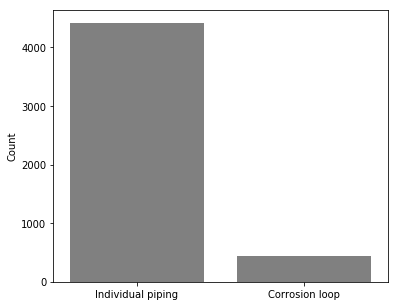

In [22]:
print ("Mean inertia: {}".format(mean_inertia))
print ("Total number of individual piping: {}".format(len(final_df)))
print ("Number of corrosion loop: {}".format(len(final_df["CORROSION_LOOP"].unique())))
print ("Percent of component reduction: {}".format((len(final_df)-len(final_df["CORROSION_LOOP"].unique()))/len(final_df)))

X_axis = ["Individual piping","Corrosion loop"]
y_axis = [len(final_df), len(final_df["CORROSION_LOOP"].unique())]

fig, ax = plt.subplots(figsize=(6,5))
sns.barplot(x=X_axis,y=y_axis, color="grey")
ax.set_ylabel("Count")
plt.savefig('bar.png', bbox_inches='tight')

# 5.0. Verification of the Algorithm

In [23]:
def pressure_temperature_variance(df,feature):
    max_press = df.groupby(feature)["OPERATING_PRESS(BARG)"].aggregate(np.max)
    min_press = df.groupby(feature)["OPERATING_PRESS(BARG)"].aggregate(np.min)
    diff_press_corrloop = (max_press - min_press)
    max_diff_press_corrloop = diff_press_corrloop.max()
    mean_diff_press_corrloop = diff_press_corrloop.mean()
    std_diff_press_corrloop = diff_press_corrloop.std()
    max_temp = df.groupby(feature)["OPERATING_TEMP(C)"].aggregate(np.max)
    min_temp = df.groupby(feature)["OPERATING_TEMP(C)"].aggregate(np.min)
    diff_temp_corrloop = (max_temp - min_temp)
    max_diff_temp_corrloop = diff_temp_corrloop.max()
    mean_diff_temp_corrloop = diff_temp_corrloop.mean()
    std_diff_temp_corrloop = diff_temp_corrloop.std()
    return max_diff_press_corrloop,mean_diff_press_corrloop,std_diff_press_corrloop,max_diff_temp_corrloop,mean_diff_temp_corrloop,std_diff_temp_corrloop

In [24]:
# Pressure and temperature variance for corrosion loop
max_diff_press_corrloop,mean_diff_press_corrloop,std_diff_press_corrloop,max_diff_temp_corrloop,mean_diff_temp_corrloop,std_diff_temp_corrloop = pressure_temperature_variance(final_df,"CORROSION_LOOP") 

print ("Corrosion loop pressure difference (max): {}".format(max_diff_press_corrloop))
print ("Corrosion loop pressure difference (mean): {}".format(mean_diff_press_corrloop))
print ("Corrosion loop pressure difference (std): {}".format(std_diff_press_corrloop))
print ("")
print ("Corrosion loop temperature difference (max): {}".format(max_diff_temp_corrloop))
print ("Corrosion loop temperature difference (mean): {}".format(mean_diff_temp_corrloop))
print ("Corrosion loop temperature difference (std): {}".format(std_diff_temp_corrloop))

Corrosion loop pressure difference (max): 0.9999999999999996
Corrosion loop pressure difference (mean): 0.07827586206896543
Corrosion loop pressure difference (std): 0.2067813851300305

Corrosion loop temperature difference (max): 9.0
Corrosion loop temperature difference (mean): 0.1429885057471264
Corrosion loop temperature difference (std): 0.7815058649289005


# 6.0. Comparison between algorithm and manual work

### Algorithm result

In [25]:
final_df_test_1025_80, mean_inertia_test_1025_80 = corrosion_loop(piping_groupings, 80, 10.25)

max_diff_press_pipgroup_1025_80, mean_diff_press_pipgroup_1025_80, std_diff_press_pipgroup_1025_80, max_diff_temp_pipgroup_1025_80, mean_diff_temp_pipgroup_1025_80, std_diff_temp_pipgroup_1025_80 = pressure_temperature_variance(final_df_test_1025_80,"CORROSION_LOOP") 
print("Total number of piping group: {}".format(len(final_df_test_1025_80["CORROSION_LOOP"].unique())))
print("Mean inertia: {}".format(mean_inertia_test_1025_80))
print ("")
print ("Corrosion loop pressure difference (max): {}".format(max_diff_press_pipgroup_1025_80))
print ("Corrosion loop pressure difference (mean): {}".format(mean_diff_press_pipgroup_1025_80))
print ("Corrosion loop pressure difference (std): {}".format(std_diff_press_pipgroup_1025_80))
print ("")
print ("Corrosion loop temperature difference (max): {}".format(max_diff_temp_pipgroup_1025_80))
print ("Corrosion loop temperature difference (mean): {}".format(mean_diff_temp_pipgroup_1025_80))
print ("Corrosion loop temperature difference (std): {}".format(std_diff_temp_pipgroup_1025_80))

Total number of piping group: 256
Mean inertia: 668.8359170768148

Corrosion loop pressure difference (max): 10.0
Corrosion loop pressure difference (mean): 1.174609375
Corrosion loop pressure difference (std): 2.4490614136027777

Corrosion loop temperature difference (max): 77.0
Corrosion loop temperature difference (mean): 4.272265625
Corrosion loop temperature difference (std): 11.63501023128507


### Manual work result 

In [26]:
# Pressure variance and temperature variance for piping group
max_diff_press_pipgroup,mean_diff_press_pipgroup,std_diff_press_pipgroup,max_diff_temp_pipgroup,mean_diff_temp_pipgroup,std_diff_temp_pipgroup = pressure_temperature_variance(final_df,"PIPING_GROUP")

print("Total number of piping group: {}".format(len(final_df["PIPING_GROUP"].unique())))
print ("")
print ("Corrosion loop pressure difference (max): {}".format(max_diff_press_pipgroup))
print ("Corrosion loop pressure difference (mean): {}".format(mean_diff_press_pipgroup))
print ("Corrosion loop pressure difference (std): {}".format(std_diff_press_pipgroup))
print ("")
print ("Corrosion loop temperature difference (max): {}".format(max_diff_temp_pipgroup))
print ("Corrosion loop temperature difference (mean): {}".format(mean_diff_temp_pipgroup))
print ("Corrosion loop temperature difference (std): {}".format(std_diff_temp_pipgroup))

Total number of piping group: 256

Corrosion loop pressure difference (max): 67.0
Corrosion loop pressure difference (mean): 2.4406249999999994
Corrosion loop pressure difference (std): 7.630181942168097

Corrosion loop temperature difference (max): 130.0
Corrosion loop temperature difference (mean): 7.578906249999999
Corrosion loop temperature difference (std): 20.44060607805539


In [27]:
#For computing average inertia with standard scaler and all features
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

def corrosion_loop_inertia_standardscaler_all(df,column):
    features = ['UNIT', 'FLUID_CODE', 'PIPING_SPEC','PHASE', 'OPERATING_PRESS(BARG)', 
                'OPERATING_TEMP(C)','INSULATION_CODE', 'PAINT']
    df_dummies = df[features]
    df_dummies = pd.get_dummies(df_dummies)
    
    list_inertia = []
    
    #Scaling features
    for col in df_dummies.columns:
        df_dummies[col] = StandardScaler().fit_transform(df_dummies[col].values.reshape(-1,1))
    
    final_features = df_dummies.columns
    
    df_dummies["CORROSION_LOOP"] = df["CORROSION_LOOP"]
    df_dummies["PIPING_GROUP"] = df["PIPING_GROUP"]
    grouped_df = df_dummies.groupby(column)
    
    #Calculating inertia
    for key, row in grouped_df:
        group_inertia = []
        for col in final_features:
            dist = (row[col] - np.mean(row[col]))**2
            group_inertia.append(np.sum(dist))
        sum_inertia = np.sum(group_inertia)
        list_inertia.append(sum_inertia)
    avg_inertia = np.mean(list_inertia)
    
    return avg_inertia, list_inertia

In [28]:
avg_inertia_kmeans, list_inertia_kmeans = corrosion_loop_inertia_standardscaler_all(final_df_test_1025_80,"CORROSION_LOOP")
std_inertia_kmeans = np.std(list_inertia_kmeans)
n_kmeans = len(list_inertia_kmeans)
print("Average inertia value of the algorithm: {}".format(avg_inertia_kmeans))
print("Standard deviation of inertia value of the algorithm: {}".format(std_inertia_kmeans))
print("Number of corrosion loop from the algorithm: {}".format(n_kmeans))

Average inertia value of the algorithm: 0.3903523589289577
Standard deviation of inertia value of the algorithm: 2.4992826229969882
Number of corrosion loop from the algorithm: 256


In [29]:
avg_inertia_mwork, list_inertia_mwork = corrosion_loop_inertia_standardscaler_all(final_df_test_1025_80,"PIPING_GROUP")
std_inertia_mwork = np.std(list_inertia_mwork)
n_mwork = len(list_inertia_mwork)
print("Average inertia value of the manual work: {}".format(avg_inertia_mwork))
print("Standard deviation of inertia value of the manual work: {}".format(std_inertia_mwork))
print("Number of corrosion loop from the manual work: {}".format(n_mwork))

Average inertia value of the manual work: 26.609086362999
Standard deviation of inertia value of the manual work: 167.53077682028368
Number of corrosion loop from the manual work: 256


In [30]:
#Use 2 sample t-test with non-equal variance
from scipy.stats import ttest_ind

test_ttest = ttest_ind(list_inertia_mwork, list_inertia_kmeans, equal_var=False)
test_ttest

Ttest_indResult(statistic=2.4988424967713896, pvalue=0.013089550785996244)

In [31]:
#t-test standard error of mean difference
def t_test_avg_std_n(n1,n2,s1,s2):
    return np.sqrt(((s1**2)/n1) + ((s2**2)/n2))

avg_std_ttest_n_eq_var = t_test_avg_std_n(n_mwork,n_kmeans,std_inertia_mwork,std_inertia_kmeans)
print("Standard error of mean difference: {}".format(avg_std_ttest_n_eq_var))

Standard error of mean difference: 10.471838648033986


In [32]:
#Degree of freedom calculation
def df_n_eq_var(n1,n2,s1,s2):
    x = (((s1**2)/n1) + ((s2**2)/n2))**2
    y = ((((s1**2)/n1)**2)/(n1-1)) + ((((s2**2)/n2)**2)/(n2-1))
    return x/y

df_n_eq = df_n_eq_var(n_mwork,n_kmeans,std_inertia_mwork,std_inertia_kmeans)
print("Degree of Freedom: {}".format(df_n_eq))

Degree of Freedom: 255.113504136565


In [33]:
#95% confidence interval
upper = (avg_inertia_mwork-avg_inertia_kmeans) + 1.96*(avg_std_ttest_n_eq_var)
lower = (avg_inertia_mwork-avg_inertia_kmeans) - 1.96*(avg_std_ttest_n_eq_var)
print("Upper limit 95% confidence interval: {}".format(upper))
print("Lower limit 95% confidence interval: {}".format(lower))

Upper limit 95% confidence interval: 46.74353775421665
Lower limit 95% confidence interval: 5.693930253923433
